## Take merged tif files as input, perform background subtract, normalize, maxproject for CP 
## Take merged tif files as input, perform Matching pursuit

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
import pandas as pd
import xml.etree.ElementTree as et

import datetime
from imageio import volread as imread
import tifffile
#from pystackreg import StackReg
from skimage.filters import threshold_otsu

import seaborn as sns
#from pystackreg.util import to_uint16

In [4]:
os.getcwd()

'/mnt/disks/store'

In [5]:
###################### USER INPUT ####################################################################
# define input directory
# fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed
DATA_DIR = '102622_D21_Coverslip9_Processed'
Z = 10
final_ch = 38
if not os.path.exists(DATA_DIR): 
    os.mkdir(DATA_DIR)

##########################################################################################
SOURCE = f'gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/{DATA_DIR}/'
MAX_DIR = 'max'
IN_DIR = 'merged'
MP_DIR = 'mp_score' # output directory to save 
MP_MAX_DIR = 'mp_score_max'
CP_DIR = 'max_clean'

META_DIR = 'metadata'
####################################################################################
DIRS = [MAX_DIR, IN_DIR, MP_DIR, MP_MAX_DIR, CP_DIR]
print("Verifying Input Directories")
print(DIRS)
for DIR in DIRS:
    if not os.path.exists(f'{DATA_DIR}/{DIR}'):
        os.mkdir(f'{DATA_DIR}/{DIR}')

os.chdir(f'{DATA_DIR}')
print(os.getcwd())
print(glob.glob('./*'))

Verifying Input Directories
['max', 'merged', 'mp_score', 'mp_score_max', 'max_clean']
/mnt/disks/store/102622_D21_Coverslip9_Processed
['./merged', './max_clean', './max', './mp_score', './mp_score_max']


,channel_number,cycle_number,marker_name,Filter,excitation_wavelength,emission_wavelength,Bandwidth,ch_index,Split_Num
0,1,0,DNA_0,DAPI,405,445,46,0,0
1,2,0,Blank_488_0,GFP,488,521,38,1,1
2,3,0,Blank_561_0,RFP,561,594,43,2,2
3,4,0,Blank_637_0,Cy5,637,698,77,3,3
4,5,1,DNA_1,DAPI,405,445,46,0,4


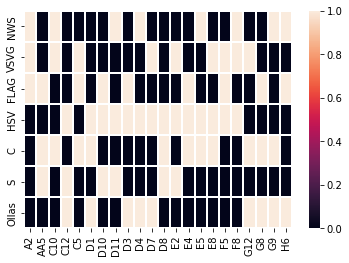

In [6]:
# load metadata - load full codebook as well
full_codebook = pd.read_csv(f'../{META_DIR}/full_codebook.csv',sep=',', index_col=0) # this is "legal" codebook
Procode_gRNA = pd.read_csv(f'../{META_DIR}/PROCODE_gRNA.csv',sep=',')
legal_codes = sorted(list(set(Procode_gRNA['ProCode ID'].to_list())))
codebook = full_codebook[legal_codes]
#AllProcodes = pd.read_csv('AllProcodes.csv', sep='.')
sns.heatmap(codebook, linewidths = 0.3)
markers = pd.read_csv(f'../{META_DIR}/markers.csv')
markers.head()


In [7]:
print(os.getcwd())

/mnt/disks/store/102622_D21_Coverslip9_Processed


In [8]:
def BackgroundSubtract2D(img, markers): # 112222 final version?
    if img.dtype != np.float32:
        img = img.astype(np.float32)
    print("Channel Size ", img.shape[0])
    
    ## Background Subtraction ## ALL CHANNELS except DNA channels
    for ch in range(4, img.shape[0]):
        if markers.loc[ch,'excitation_wavelength'] == 488:
            img[ch,...] = img[ch,...] - img[1,...] # subtract background      
        elif markers.loc[ch,'excitation_wavelength'] == 561:
            img[ch,...] = img[ch,...] - img[2,...] # subtract background  
        elif markers.loc[ch,'excitation_wavelength'] == 637: 
            img[ch,...] = img[ch,...] - img[3,...] # subtract background 
        elif markers.loc[ch,'excitation_wavelength'] == 514: # for SYTO channel
            img[ch,...] = img[ch,...] - img[1,...] # subtract background      
        img[img<0] = 0 # clip negatives 
    return img

# img has to be CZYX        
def QuantileNormalize(img, MIN, MAX):    
    # include assert error checking for img shape = CZYX this function only works in CZYX or CYX format.
    # calculate normalization factors
    img_min = np.quantile(img,MIN,tuple(range(1,len(img.shape))),keepdims=True) # most of each channel is probably background
    img_max = np.quantile(img,MAX,tuple(range(1,len(img.shape))),keepdims=True)      
    img = (img.astype(np.float32) - img_min) / (img_max - img_min)
    img = img.clip(0,1) # clip negatives 
    img = img.astype(np.float32)
    return img # bcg subtracted, epitope channel selected, median filtered and min/max normalized 

In [9]:
def prepare_MPinput(img, codebook, markers): # 112222 final version?
    from skimage.filters import median
    from skimage.morphology import disk

    if img.dtype != np.float32:
        img = img.astype(np.float32)
    
    if img.shape[0] != len(markers.index.tolist()):
        img = img.transpose(1,0,2,3)
    assert img.shape[0] == len(markers.index.tolist()), 'image input should be transposed to CZYX'
    print("Channel Size ", img.shape[0])
    
    ## Background Subtraction ## ALL CHANNELS except DNA channels
    for ch in range(4, img.shape[0]):
        if markers.loc[ch,'excitation_wavelength'] == 488:
            img[ch,...] = img[ch,...] - img[1,...] # subtract background      
        elif markers.loc[ch,'excitation_wavelength'] == 561:
            img[ch,...] = img[ch,...] - img[2,...] # subtract background  
        elif markers.loc[ch,'excitation_wavelength'] == 637: 
            img[ch,...] = img[ch,...] - img[3,...] # subtract background 
        elif markers.loc[ch,'excitation_wavelength'] == 514: # for SYTO channel
            img[ch,...] = img[ch,...] - img[1,...] # subtract background      
        img[img<0] = 0 # clip negatives 
    
    ### THIS IS IMPORTANT -- do median filter of only EPITOPE channels.
    img = img[markers['marker_name'].isin(codebook.index)]
 
    # median filter - ####### DO IT before calculating quantiles
    # median filter of only epitope channels !!!! 
    _img = np.zeros(np.shape(img), dtype = np.float32)
    for C in range(img.shape[0]):
        for Z in range(img.shape[1]):
            _img[C,Z,...] = median(img[C,Z,...], disk(1))

    # calculate normalization factors
    img_min = np.quantile(_img,0.75,(1,2,3),keepdims=True) # most of each channel is probably background
    img_max = np.quantile(_img,0.999,(1,2,3),keepdims=True)      
    img = (img.astype(np.float32) - img_min) / (img_max - img_min)
    img = img.clip(0,1) # clip negatives 
    return img # bcg subtracted, epitope channel selected, median filtered and min/max normalized 


# approximately solve min_z ||zA-x||^2_2 st ||z||_0 <= max_iters
def matching_pursuit(x, A, max_iters, thr=1):
    # this is necessary if doing more than one iteration, for the residuals update to work
    from skimage.filters import threshold_otsu
    A = A / np.linalg.norm(A,axis=1)[:,None]
    z = np.zeros((A.shape[0],*x.shape[1:]))
    x = x.copy() # initialize "residuals" to the image itself
    # mask for whether each pixel has converged or not; we already know background's zero
    active_set = np.ones(x.shape[1:],dtype=bool)
    x_norm = np.linalg.norm(x,axis=0,ord=2)

    # one approach: pick it using the otsu threshold, as estimate of noise level
    max_norm = threshold_otsu(x_norm)
#     max_norm = [threshold_otsu(x_norm[k]) for k in range(x_norm.shape[0])]
#     max_norm = np.array(max_norm)[:,None,None]
    max_norm *= thr # hack; otsu just not great. see 'enhance neurites' in CellProfiler?
    active_set[x_norm <= max_norm] = False
    for t in range(max_iters):
        # project dictionary on residual image
        Ax = A @ x[:,active_set]
        # pick index with max projection
        k_max = Ax.argmax(0)
        # set it to active
        z[k_max,active_set] = Ax[k_max,range(len(k_max))]
        # subtract off contribution
        x[:,active_set] -= A[k_max].T * z[k_max,active_set]
        # mark pixels with sufficiently small residual norm as done
        x_norm = np.linalg.norm(x,axis=0,ord=2)
        active_set[x_norm<max_norm] &= False
        
    return z

In [10]:
# get indices of final channels
final_inds = []
marker_names = ['DNA_0','NWS','VSVG','FLAG','HSV','C','S','Ollas','GFAP','NeuN',
               'pRPS6','RANGAP1','NFKB','TOM20','LAMP1','4HNE','TDP43','G3BP1','GM130','Calnexin','Golgin97',
               'SYTO','ER','AGP','Catalase']

for marker in marker_names:
    ind_to_add = markers[markers.marker_name == marker]['Split_Num'].values[0]
    final_inds.append(ind_to_add)
final_inds

[0,
 5,
 6,
 7,
 9,
 10,
 11,
 13,
 14,
 15,
 17,
 18,
 19,
 21,
 22,
 23,
 25,
 27,
 29,
 30,
 31,
 33,
 35,
 36,
 37]

In [11]:
print(SOURCE)

gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/


In [12]:
# get the lowest size data to extract FOV numbers
dir_to_make = 'reg_bin_Cyc_1'
if not os.path.exists(dir_to_make):
    os.mkdir(dir_to_make)

cmd = f'gsutil -m rsync -r {SOURCE+dir_to_make} {dir_to_make}'
! {cmd}

Building synchronization state...
Starting synchronization...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F000_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F016_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F041_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F018_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F001_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F036_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/

Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F110_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F066_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F014_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F046_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F039_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F061_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F034_bin_reg.tif...
Copying gs://fc-secu

Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F132_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F129_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F115_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F131_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F142_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F137_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F134_bin_reg.tif...
Copying gs://fc-secu

Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F194_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F195_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F196_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F200_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F199_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F197_bin_reg.tif...
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/reg_bin_Cyc_1/Cycle_1_F198_bin_reg.tif...
Copying gs://fc-secu

In [13]:
# extract FOV numbers.
_allFOVs = sorted(glob.glob('reg_bin_Cyc_1/*'))
allFOVs = [x.split('F')[-1][:3] for x in _allFOVs]
print(allFOVs)
print(len(allFOVs))

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '022', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '052', '053', '054', '055', '056', '057', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '137', '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153'

In [14]:
for ii in range(0,len(allFOVs),10): # For each CHUNK (10 FOVs per loop)
    print(allFOVs[ii:ii+10])

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
['010', '011', '012', '013', '014', '015', '016', '017', '018', '019']
['020', '022', '024', '025', '026', '027', '028', '029', '030', '031']
['032', '033', '034', '035', '036', '039', '040', '041', '042', '043']
['044', '045', '046', '047', '048', '049', '050', '052', '053', '054']
['055', '056', '057', '059', '060', '061', '062', '063', '064', '065']
['066', '067', '068', '069', '070', '071', '073', '074', '075', '076']
['077', '078', '079', '080', '081', '082', '084', '085', '086', '087']
['088', '089', '090', '091', '092', '093', '094', '095', '096', '097']
['098', '099', '100', '101', '102', '103', '104', '105', '107', '108']
['109', '110', '111', '112', '113', '114', '115', '116', '117', '118']
['119', '120', '121', '122', '123', '124', '125', '126', '127', '128']
['129', '130', '131', '132', '133', '134', '135', '137', '138', '140']
['141', '142', '143', '144', '145', '146', '147', '148', '149', '150']
['151'

In [ ]:
for ii in range(0,len(allFOVs),10): # For each CHUNK (10 FOVs per loop)
    print(allFOVs[ii:ii+10])
    
    # download chunk
    for fov in allFOVs[ii:ii+10]: # for each fov in CHUNK
        cmd = 'gsutil cp ' + SOURCE + IN_DIR + f'/F{fov}.tif {IN_DIR}'
        print(cmd)
        ! {cmd}
        
        img_merged = imread(f'{IN_DIR}/F{fov}.tif') # load input image
        print(img_merged.shape)
        
        # Prepare CP inputs - final inds and max-project
        print("Prepare CP inputs - max projection only")
        img_max = img_merged.max(0) # take max projection # ZCYX
        im_to_save = img_max[final_inds].copy()
        fname = f'F{fov}_max.tif'
        
        print('Saving MAX...', f'./{MAX_DIR}/fname') 
        print(im_to_save.shape)
        tifffile.imwrite(f'./{MAX_DIR}/'+fname, im_to_save, imagej = True,
                        photometric='minisblack', metadata={'axes':'CYX'})
        
        # Prepare MP inputs
        print("Prepare MP inputs")
        img_max = img_merged.max(0) # take max projection # ZCYX
        img_max = BackgroundSubtract2D(img_max, markers) # subtract background
        img_norm = QuantileNormalize(img_max, 0.75, 0.9999) ## dtype = float32 # quantile normalization, for MP
        im_to_save = img_norm[final_inds].copy()
        
        fname=f'F{fov}_max_clean.tif'
        tifffile.imwrite(f'./{CP_DIR}/'+fname, im_to_save, imagej = True,
                        photometric='minisblack', metadata={'axes':'CYX'})
        print('Saving BCG_NORM_Max_REORDERED...', f'./{CP_DIR}/'+fname) 
        export = f'gsutil cp ' + f'{CP_DIR}/'+fname + ' ' + SOURCE + CP_DIR
        print(export)
        ! {export}
    
        # MP
        print("Start Matching Pursuit")
        x = prepare_MPinput(img_merged, codebook, markers)
        A = codebook.values.copy().T
    
        max_components = 3
        fudge_factor = 0.25
    
        z = matching_pursuit(x,A,max_components, fudge_factor)
        z = z.clip(0, np.inf)
        z = z.astype(np.float32)
    
        # convert back to CZYX --> ZCYX
        z = z.transpose(1,0,2,3)
        print(z.shape)
    
        fname = f'F{fov}_mp_score.tif'
        tifffile.imwrite(f'./{MP_DIR}/'+fname, z, imagej = True,
                        photometric='minisblack', metadata={'axes':'ZCYX'})
        print('Saving 3D score map...', f'./{MP_DIR}/'+fname)
        export = f'gsutil cp ' + f'{MP_DIR}/'+fname + ' ' + SOURCE + MP_DIR
        print(export)
        ! {export}
    
        fname = f'F{fov}_mp_score_max.tif'
        tifffile.imwrite(f'./{MP_MAX_DIR}/'+fname, z.max(0), imagej = True,
                        photometric='minisblack', metadata={'axes':'CYX'})
        print('Saving 2D score map...', f'./{MP_MAX_DIR}/'+fname)  
        export = f'gsutil cp ' + f'{MP_MAX_DIR}/'+fname + ' ' + SOURCE + MP_MAX_DIR
        print(export)
        ! {export}
        
    
    
        # remove files from memory
        del img_merged
        del z
        del x
        del img_norm
        del im_to_save
        
    
        print('##############################################################################')
    
    
    # remove files 
    print("Removing exported files")
    cmd = f'rm {MP_DIR}/*'
    ! {cmd}
    
    cmd = f'rm {MP_MAX_DIR}/*'
    ! {cmd} 
    
    cmd = f'rm {CP_DIR}/*'
    ! {cmd}
    
    cmd = f'rm {MAX_DIR}/*'
    ! {cmd}
    
    # clear memory and files for next round of chunk
    print("Removing original merged...")
    cmd = f"rm {IN_DIR}/*" # merged
    ! {cmd}
    

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
gsutil cp gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/merged/F000.tif merged
Copying gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/merged/F000.tif...
\ [1 files][  3.7 GiB/  3.7 GiB]   55.7 MiB/s                                   
Operation completed over 1 objects/3.7 GiB.                                      
(13, 38, 2010, 2013)
Prepare CP inputs - max projection only
Saving MAX... ./max/fname
(25, 2010, 2013)
Prepare MP inputs
Channel Size  38
Saving BCG_NORM_Max_REORDERED... ./max_clean/F000_max_clean.tif
gsutil cp max_clean/F000_max_clean.tif gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/102622_D21_Coverslip9_Processed/max_clean
Copying file://max_clean/F000_max_clean.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you en

/home/bkang/anaconda3/envs/author/lib/python3.7/site-packages/tifffile/tifffile.py:2903: UserWarning: <tifffile.TiffWriter 'F000_mp_score.tif'> truncating ImageJ file
  warnings.warn(f'{self!r} truncating ImageJ file', UserWarning)


Copying file://mp_score/F000_mp_score.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][  4.3 GiB/  4.3 GiB]  160.7 MiB/s                                   
Operation completed over 1 objects/4.3 GiB.                                      
Saving 2D score map... ./mp_score_max/F000_mp_score_max.tif
gsutil cp mp_score_m

/home/bkang/anaconda3/envs/author/lib/python3.7/site-packages/tifffile/tifffile.py:2903: UserWarning: <tifffile.TiffWriter 'F001_mp_score.tif'> truncating ImageJ file
  warnings.warn(f'{self!r} truncating ImageJ file', UserWarning)


Copying file://mp_score/F001_mp_score.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][  4.3 GiB/  4.3 GiB]  183.2 MiB/s                                   
Operation completed over 1 objects/4.3 GiB.                                      
Saving 2D score map... ./mp_score_max/F001_mp_score_max.tif
gsutil cp mp_score_m

/home/bkang/anaconda3/envs/author/lib/python3.7/site-packages/tifffile/tifffile.py:2903: UserWarning: <tifffile.TiffWriter 'F002_mp_score.tif'> truncating ImageJ file
  warnings.warn(f'{self!r} truncating ImageJ file', UserWarning)


Copying file://mp_score/F002_mp_score.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][  4.3 GiB/  4.3 GiB]  150.6 MiB/s                                   
Operation completed over 1 objects/4.3 GiB.                                      
Saving 2D score map... ./mp_score_max/F002_mp_score_max.tif
gsutil cp mp_score_m

/home/bkang/anaconda3/envs/author/lib/python3.7/site-packages/tifffile/tifffile.py:2903: UserWarning: <tifffile.TiffWriter 'F003_mp_score.tif'> truncating ImageJ file
  warnings.warn(f'{self!r} truncating ImageJ file', UserWarning)


Copying file://mp_score/F003_mp_score.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][  4.3 GiB/  4.3 GiB]  164.2 MiB/s                                   
Operation completed over 1 objects/4.3 GiB.                                      
Saving 2D score map... ./mp_score_max/F003_mp_score_max.tif
gsutil cp mp_score_m

/home/bkang/anaconda3/envs/author/lib/python3.7/site-packages/tifffile/tifffile.py:2903: UserWarning: <tifffile.TiffWriter 'F004_mp_score.tif'> truncating ImageJ file
  warnings.warn(f'{self!r} truncating ImageJ file', UserWarning)


Copying file://mp_score/F004_mp_score.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][  4.3 GiB/  4.3 GiB]  150.7 MiB/s                                   
Operation completed over 1 objects/4.3 GiB.                                      
Saving 2D score map... ./mp_score_max/F004_mp_score_max.tif
gsutil cp mp_score_m

/home/bkang/anaconda3/envs/author/lib/python3.7/site-packages/tifffile/tifffile.py:2903: UserWarning: <tifffile.TiffWriter 'F005_mp_score.tif'> truncating ImageJ file
  warnings.warn(f'{self!r} truncating ImageJ file', UserWarning)


Copying file://mp_score/F005_mp_score.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][  4.3 GiB/  4.3 GiB]  117.6 MiB/s                                   
Operation completed over 1 objects/4.3 GiB.                                      
Saving 2D score map... ./mp_score_max/F005_mp_score_max.tif
gsutil cp mp_score_m

In [ ]:
# verify MP output - download one randomly


In [ ]:
A.shape

In [ ]:
#z=z.transpose(1,0,2,3)
cm = plt.get_cmap('tab20')
cm.set_bad('k')
plt.figure(figsize=(12,12))
plt.gca().matshow(np.where(z.max(1).max(0)==0,np.nan,z.max(1).argmax(0)),cmap=cm)

In [ ]:
x.shape

In [ ]:
fig,axs= plt.subplots(2,4,figsize=(20,10))
axs=axs.ravel()
for i in range((x.shape[0])):
    axs[i].imshow(x.max(1)[i])


In [ ]:
im_max = imread(f'{CP_DIR}/F000_max_clean.tif')
im_max.shape

In [ ]:
fig,axs= plt.subplots(5,5,figsize=(25,25))
axs=axs.ravel()
for i in range((im_max.shape[0])):
    axs[i].imshow(im_max[i, :1000,:1000])


In [ ]:
fig,axs= plt.subplots(5,5,figsize=(25,25))
axs=axs.ravel()
for i in range((im_max.shape[0])):
    axs[i].imshow(im_max[i, :1000,:1000], vmin=np.quantile(im_max[i],0.05), 
                 vmax = np.quantile(im_max[i], 0.95))


In [ ]:
img_merged.shape

In [ ]:
fig,axs= plt.subplots(5,8,figsize=(25,25))
axs=axs.ravel()
for i in range((im_max.shape[0])):
    axs[i].imshow(img_merged.max(0)[i, :1000,:1000], vmin=np.quantile(img_merged.max(0)[i],0.05), 
                 vmax = np.quantile(img_merged.max[i], 0.95))
